In [6]:
import sys, os
sys.path.append('../src')
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralstocks.dataacquisition import *
from neuralstocks.plots import *
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

%matplotlib inline

In [7]:
dataPath = '../../data'
assetType = 'stocks'
asset = 'PETR4'
frequency = 'diario'
filePath = dataPath + '/' + assetType + '/' + asset + '/' + frequency + '/' + asset + '.CSV'

decomposeModel = 'additive'

saveDir = '../../results/preprocessing/misc'
if not os.path.exists(saveDir):
    os.makedirs(saveDir)
saveFormat = 'png'

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

In [8]:
init_time = time.time()
PETR4 = acquireData(filePath = filePath,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], ['Close', 'Open']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}, 
                                 {'column': 'Volume', 'lenght': 21}],
                    MACDParams = [{'fast_lenght': 12, 'slow_lenght': 26, 'signal_lenght': 9}],
                    BBParams = [{'lenght': 20}],
                    OBVParams = [{'lenght': None}],
                    deTrendParams = {'column': 'Close', 'window': 6, 'model': decomposeModel, 
                                     'weightModel': 'window_acorr', 'weightModelWindow': 18},
                    colPrefix = None,
                    dropNan = True)

columnsToKeep = ['Holiday', 'Close_rollStd20', 'Close_EMA17_logdiff', 'Close_EMA72_logdiff',
                 'Close_EMA200_logdiff', 'Volume_EMA21_logdiff', 'MACD_12_26_9', 'MACDsignal_12_26_9', 'Bollinger%b_20',
                 'OBV', 'Close_returns', 'Close/Open_returns', 'Close_resid']
PETR4 = PETR4[columnsToKeep]

end_time = time.time()
print 'Time to acquire and process data: '+str(end_time-init_time)+' seconds'

Time to acquire and process data: 9.15766882896 seconds


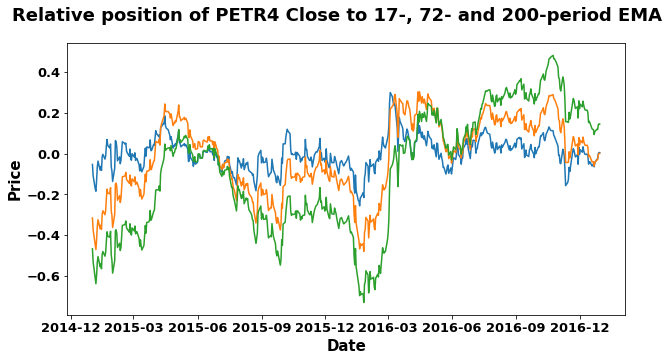

In [9]:
plotSeries(PETR4[['Close_EMA17_logdiff', 'Close_EMA72_logdiff', 'Close_EMA200_logdiff']], 
           title = 'Relative position of {} Close to 17-, 72- and 200-period EMA'.format(asset), ylabel = 'Price', 
           initialPlotDate = '2015', finalPlotDate = '2016')

In [10]:
PETR4_scalled = None
scaler = MinMaxScaler(feature_range = (-1,1))
scaler.fit(PETR4)
PETR4_scalled = pd.DataFrame(scaler.transform(PETR4), columns = PETR4.columns.values, index = PETR4.index)

#scatterHist(PETR4['Close_EMA17_logdiff'], PETR4_scalled['Close_EMA17_logdiff'], nBins = 100)

In [31]:
xTrain, yTrain, xTest, yTest = prepData2(df = PETR4, 
                                        columnsToUse = columnsToKeep, columnToPredict = 'Close_resid', 
                                        nDelays = 10, testSetSize = len(PETR4['2017']))

numberOfBatches = len(xTrain)
numberOfInputs = len(xTrain[0])
print 'Number of train batches: {}'.format(numberOfBatches)
print 'Number of inputs per batch: {}'.format(numberOfInputs)


Number of train batches: 4185
Number of inputs per batch: 130


In [39]:
init_time = time.time()

model = Sequential([Dense(25, activation = 'tanh', input_dim = 130),
                    Dense(5, activation = 'tanh'),
                    Dense(1, activation = 'tanh')])

model.compile(optimizer='rmsprop', loss='mse')

end_time = time.time()
print 'Time to build model: '+str(end_time-init_time)+' seconds'
model.summary()

Time to build model: 0.0284829139709 seconds
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 25)                3275      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 130       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6         
Total params: 3,411
Trainable params: 3,411
Non-trainable params: 0
_________________________________________________________________


In [41]:
init_time = time.time()

model.fit(xTrain, 
          yTrain, 
          epochs = 300,
          verbose = 0,
          validation_split = 0.10)

end_time = time.time()
print 'Time to fit model: '+str(end_time-init_time)+' seconds'

Time to fit model: 21.8296558857 seconds


In [42]:
model.evaluate(xTest, yTest, verbose=1)


 32/175 [====>.........................] - ETA: 0s

0.14783594995737076

In [30]:
def prepData2(df, columnsToUse, columnToPredict, nDelays, testSetSize):
    xTrain = []
    yTrain = []
    xTest = []
    yTest = []
    for i in range(len(df)):
        xTrainAux = []
        yTrainAux = []
        xTestAux = []
        yTestAux = []
        if i >= nDelays and (i < (len(df) - testSetSize)):
            for column in columnsToUse:
                xTrainAux.extend(df[column][i - nDelays : i])
            yTrainAux.append(df[columnToPredict][i])
            xTrain.append(xTrainAux)
            yTrain.append(yTrainAux)
        elif i >= nDelays and (i >= (len(df) - testSetSize)):
            for column in columnsToUse:
                xTestAux.extend(df[column][i - nDelays : i])
            yTestAux.append(df[columnToPredict][i])
            xTest.append(xTestAux)
            yTest.append(yTestAux)

    return xTrain, yTrain, xTest, yTest

In [44]:
np.sqrt(np.square(yTest).sum()/len(yTest))

0.38449529869897325